## Assignment 1
### Ritika Giridhar (a1907667)

In [ ]:
# Install vaderSentiment to use VADER
!pip install vaderSentiment

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 3.2 MB/s eta 0:00:00


In [ ]:
# Necessary imports
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import json
import nltk
from wordcloud import WordCloud
from collections import Counter
from itertools import chain
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from scipy.sparse import hstack, csr_matrix
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score,
    confusion_matrix,
    classification_report,
    accuracy_score
)

# Necessary nltk resources
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

### 1. Reading datasets

In [ ]:
# Load .json file line by line
def load_data(file_path):
    data = []
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            try:
                json_object = json.loads(line)
                data.append(json_object)
            except json.JSONDecodeError as e:
                print(f"Error loading line: {e}")
    return data

# Load the dataset
data = load_data('/content/random_30000_hotel_reviews.JSON')

# Convert to DataFrame
df = pd.DataFrame(data)

# Extract the nested 'overall' rating field
df['overall'] = df['ratings'].apply(lambda x: x.get('overall') if isinstance(x, dict) else None)

# Split into training, development, and test sets
train_df = df[:10000]
dev_df = df[10000:20000]
test_df = df[20000:]

# Basic data cleaning
def clean_text(text):
    if isinstance(text, str):
        # Remove non-alphanumeric characters and convert to lowercase
        text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
        # Tokenise
        tokens = word_tokenize(text.lower())
        return tokens
    return []

# Combine title + text
train_df['combined_text'] = train_df['title'].fillna('') + ' ' + train_df['text'].fillna('')
dev_df['combined_text'] = dev_df['title'].fillna('') + ' ' + dev_df['text'].fillna('')
test_df['combined_text'] = test_df['title'].fillna('') + ' ' + test_df['text'].fillna('')

# Clean and tokenise text
train_df['tokens'] = train_df['combined_text'].apply(clean_text)
dev_df['tokens'] = dev_df['combined_text'].apply(clean_text)
test_df['tokens'] = test_df['combined_text'].apply(clean_text)

# Preview the data
print(f"Training set shape: {train_df.shape}")
print(f"Development set shape: {dev_df.shape}")
print(f"Test set shape: {test_df.shape}")
print("\nTraining set sample:")
train_df[['title', 'text', 'overall', 'tokens']].head(2)

<ipython-input-24-ec2d5ae4b34a>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['combined_text'] = train_df['title'].fillna('') + ' ' + train_df['text'].fillna('')
<ipython-input-24-ec2d5ae4b34a>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dev_df['combined_text'] = dev_df['title'].fillna('') + ' ' + dev_df['text'].fillna('')
<ipython-input-24-ec2d5ae4b34a>:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] 

Training set shape: (10000, 13)
Development set shape: (10000, 13)
Test set shape: (10000, 13)

Training set sample:


<ipython-input-24-ec2d5ae4b34a>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['tokens'] = test_df['combined_text'].apply(clean_text)


,title,text,overall,tokens
0,“Horrible experience”,First of all we got there and they didn't have...,1.0,"[horrible, experience, first, of, all, we, got..."
1,“Stay Away”,Found Racist graffiti in the room. Request to ...,1.0,"[stay, away, found, racist, graffiti, in, the,..."


### 2. Exploratory Data Analysis (EDA)

In [ ]:
# Check for missing values
print("Missing values in dev dataset:")
print(dev_df.isnull().sum())

# Check data types
print("\nData types:")
print(dev_df.dtypes)

Missing values in dev dataset:
ratings                0
title                  0
text                   0
author                 0
date_stayed          398
offering_id            0
num_helpful_votes      0
date                   0
id                     0
via_mobile             0
overall                0
combined_text          0
tokens                 0
dtype: int64

Data types:
ratings               object
title                 object
text                  object
author                object
date_stayed           object
offering_id            int64
num_helpful_votes      int64
date                  object
id                     int64
via_mobile              bool
overall              float64
combined_text         object
tokens                object
dtype: object


There are no missing values in the key columns, "title" and "text." The only column with missing values is "date_stayed," however, it does not need to be dropped since it is not relevant to predicting the overall rating.

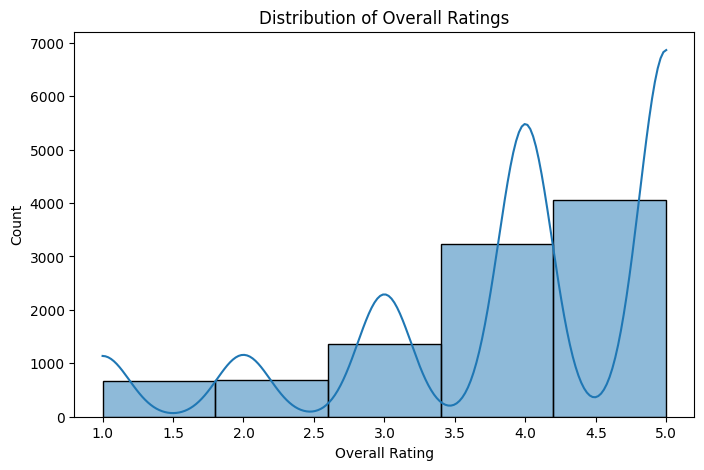

In [ ]:
# Distribution of overall ratings
plt.figure(figsize=(8,5))
sns.histplot(dev_df['overall'], bins=5, kde=True)
plt.xlabel("Overall Rating")
plt.ylabel("Count")
plt.title("Distribution of Overall Ratings")
plt.show()


The distribution of overall ratings in the dev dataset is right-skewed, with a higher concentration of ratings around 4.0 and 5.0, indicating a tendency towards positive reviews. Lower ratings (1.0 and 2.0) appear less frequent, suggesting fewer negative experiences. The density plot highlights peaks at 3.0, 4.0, and 5.0, reflecting common rating preferences.

<ipython-input-10-afe321e9cedc>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dev_df['title_length'] = dev_df['title'].apply(lambda x: len(x.split()) if isinstance(x, str) else 0)
<ipython-input-10-afe321e9cedc>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dev_df['text_length'] = dev_df['text'].apply(lambda x: len(x.split()) if isinstance(x, str) else 0)
<ipython-input-10-afe321e9cedc>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

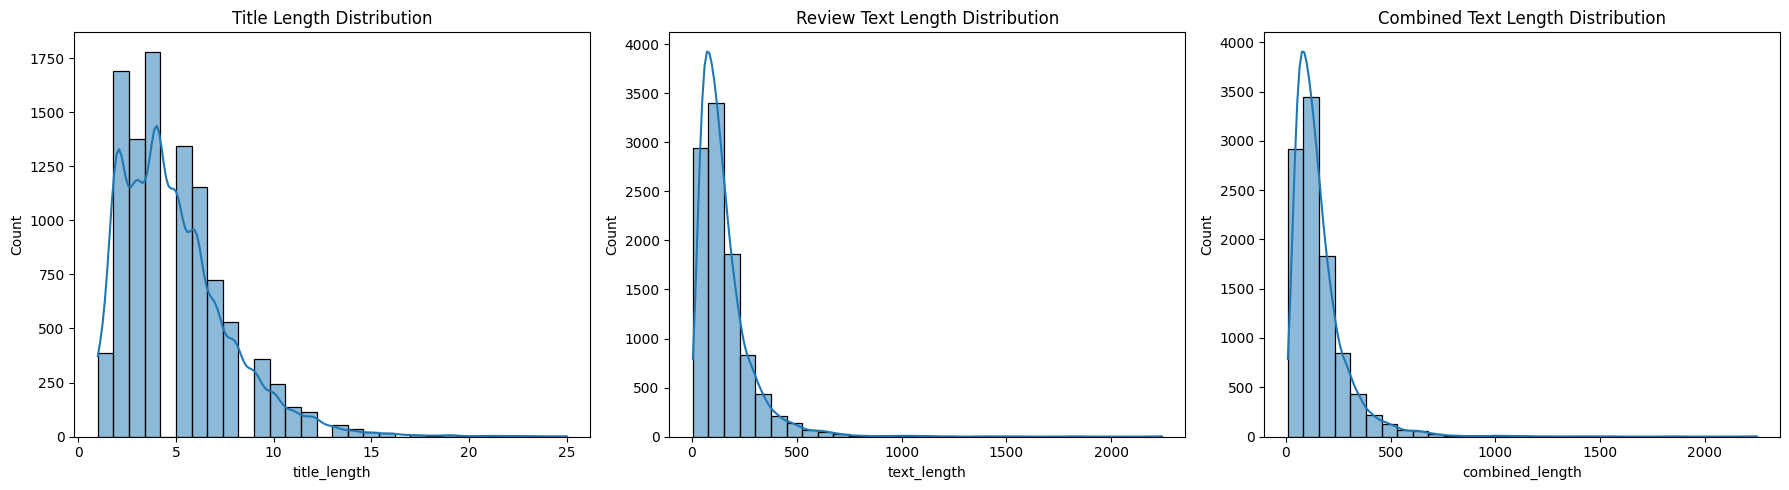

In [ ]:
# Calculate text statistics
dev_df['title_length'] = dev_df['title'].apply(lambda x: len(x.split()) if isinstance(x, str) else 0)
dev_df['text_length'] = dev_df['text'].apply(lambda x: len(x.split()) if isinstance(x, str) else 0)
dev_df['combined_length'] = dev_df['combined_text'].apply(lambda x: len(x.split()) if isinstance(x, str) else 0)

# Plot text length distributions
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
sns.histplot(dev_df['title_length'], bins=30, kde=True, ax=axes[0])
axes[0].set_title('Title Length Distribution')
sns.histplot(dev_df['text_length'], bins=30, kde=True, ax=axes[1])
axes[1].set_title('Review Text Length Distribution')
sns.histplot(dev_df['combined_length'], bins=30, kde=True, ax=axes[2])
axes[2].set_title('Combined Text Length Distribution')
plt.tight_layout()
plt.show()

The distributions of title, review text, and combined text lengths are all right-skewed, indicating that most reviews are relatively short, with a few longer ones. Titles are generally concise, with a peak of around 3-6 words, while review texts and combined texts show a higher frequency of shorter lengths, gradually tapering off. The similarity in the distributions of text_length and combined_length suggests that the title contributes only a small portion to the overall review length.

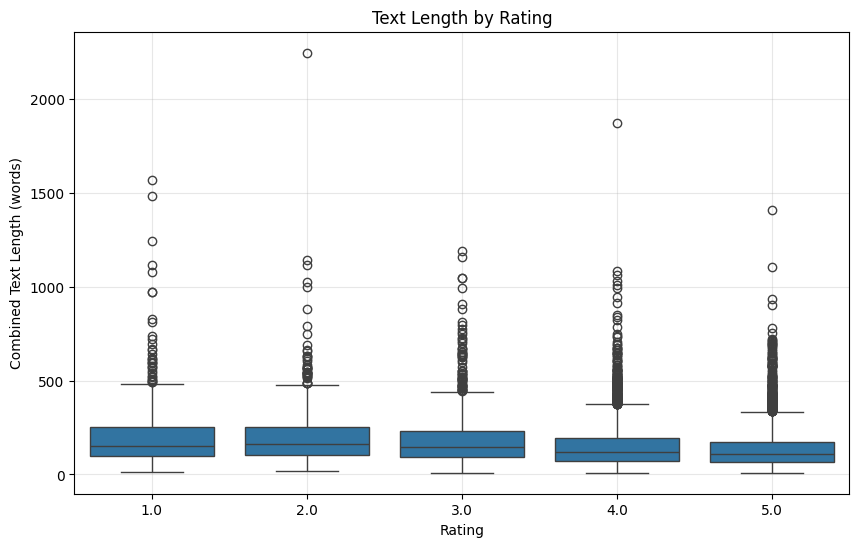

In [ ]:
# Relationship between text length and rating
plt.figure(figsize=(10, 6))
sns.boxplot(x='overall', y='combined_length', data=dev_df)
plt.title('Text Length by Rating')
plt.xlabel('Rating')
plt.ylabel('Combined Text Length (words)')
plt.grid(True, alpha=0.3)
plt.show()

The median review length remains consistent across all ratings, indicating that longer reviews aren't inherently more positive or negative. However, there are several outliers, with some exceptionally long reviews appearing in every rating category; a few guests provide highly detailed feedback, potentially impacting the model's predictions.

In [ ]:
# Count unique words
all_words = [word for tokens in dev_df['tokens'] for word in tokens]
unique_words = set(all_words)
print(f"\nTotal words in dev dataset: {len(all_words)}")
print(f"Unique words in dev dataset: {len(unique_words)}")


Total words in dev dataset: 1569992
Unique words in dev dataset: 32739


The dev dataset contains a rich vocabulary with a moderate level of lexical diversity. However, the relatively high number of unique words suggests potential challenges in text representation due to sparsity.

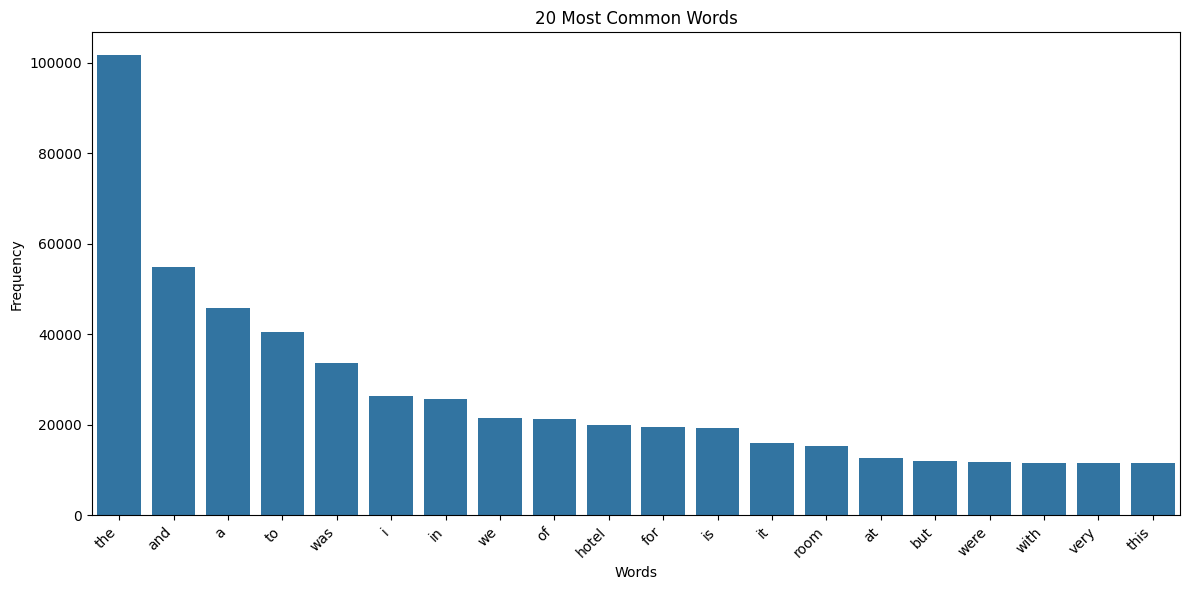

In [ ]:
# Most common words
from collections import Counter
word_counts = Counter(all_words)
most_common_words = word_counts.most_common(20)

plt.figure(figsize=(12, 6))
words, counts = zip(*most_common_words)
sns.barplot(x=list(words), y=list(counts))
plt.title('20 Most Common Words')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

High-frequency stopwords like "the," "and," "a," and "to" dominate the distribution. These words provide little semantic value for predictive modeling and should be removed or downweighted through stopword filtering or TF-IDF transformation. Words like "hotel" and "room" implies that the reviews focus heavily on accommodation experiences.

### 3. Preprocessing

In [ ]:
# Text preprocessing with different options
def preprocess_text(text, remove_stopwords=False, lemmatize=False, lowercase=True):
    if not isinstance(text, str):
        return ""

    # Lowercase if specified
    if lowercase:
        text = text.lower()

    # Remove non-alphanumeric characters
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)

    # Tokenise
    tokens = word_tokenize(text)

    # Remove stopwords if specified
    if remove_stopwords:
        stop_words = set(stopwords.words('english'))
        tokens = [word for word in tokens if word not in stop_words]

    # Lemmatize if specified
    if lemmatize:
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Join tokens back into text
    processed_text = ' '.join(tokens)

    return processed_text

# Preprocessing combinations to try
preprocessing_options = [
    (False, False, True),   # Lowercase only
    (True, False, True),    # Lowercase + stopword removal
    (False, True, True),    # Lowercase + lemmatization
    (True, True, True),     # Lowercase + stopword removal + lemmatization
]


The function implements a configurable text preprocessing pipeline, incorporating lowercasing, stopword removal, and lemmatization to enhance text normalisation for choosing the optimal model-preprocessing combination.

### 4. Selecting supervised method for sentiment classification

Evaluating Multinomial NB...
  - with SW=False, Lem=False, LC=True: RMSE = 1.1022
  - with SW=True, Lem=False, LC=True: RMSE = 1.0233
  - with SW=False, Lem=True, LC=True: RMSE = 1.1058
  - with SW=True, Lem=True, LC=True: RMSE = 1.0301
Evaluating Linear Regression...
  - with SW=False, Lem=False, LC=True: RMSE = 1.0185
  - with SW=True, Lem=False, LC=True: RMSE = 1.0394
  - with SW=False, Lem=True, LC=True: RMSE = 1.0488
  - with SW=True, Lem=True, LC=True: RMSE = 1.0649
Evaluating Ridge Regression...
  - with SW=False, Lem=False, LC=True: RMSE = 0.7206
  - with SW=True, Lem=False, LC=True: RMSE = 0.7336
  - with SW=False, Lem=True, LC=True: RMSE = 0.7218
  - with SW=True, Lem=True, LC=True: RMSE = 0.7347
Evaluating KNN...
  - with SW=False, Lem=False, LC=True: RMSE = 1.0038
  - with SW=True, Lem=False, LC=True: RMSE = 0.9081
  - with SW=False, Lem=True, LC=True: RMSE = 0.9842
  - with SW=True, Lem=True, LC=True: RMSE = 0.9090
Evaluating MLP...
  - with SW=False, Lem=False, LC=True: R

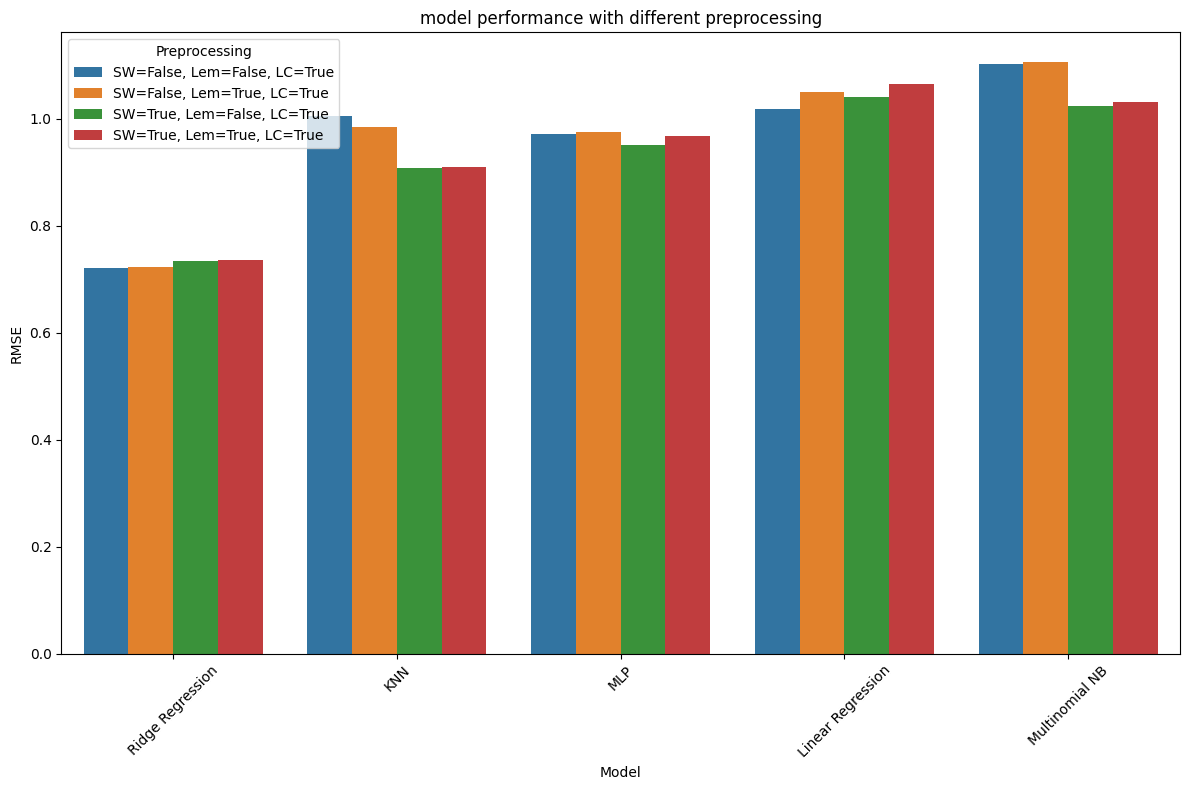


Best combination:
Model: Ridge Regression
Preprocessing: SW=False, Lem=False, LC=True
RMSE: 0.7206


In [ ]:
# Models to test
models = {
    'Multinomial NB': MultinomialNB(),
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'KNN': KNeighborsRegressor(n_neighbors=5),
    'MLP': MLPRegressor(hidden_layer_sizes=(100,), max_iter=500, random_state=42)
}

# Evaluate models with different preprocessing options
def evaluate_models_with_preprocessing(X, y, models, preprocessing_options):
    results = []

    for name, model in models.items():
        print(f"Evaluating {name}...")

        for preproc_option in preprocessing_options:
            remove_sw, lemmatize, lowercase = preproc_option
            preproc_name = f"SW={remove_sw}, Lem={lemmatize}, LC={lowercase}" # SW = stopwords, Lem = lemmatization, LC = lowercase

            try:
                # Preprocess text with current options
                processed_texts = [preprocess_text(text, remove_sw, lemmatize, lowercase)
                                  for text in X]

                # Create TF-IDF features
                vectorizer = TfidfVectorizer(max_features=5000)
                X_processed = vectorizer.fit_transform(processed_texts)

                # Perform 10-fold CV
                kf = KFold(n_splits=10, shuffle=True, random_state=42)
                scores = cross_val_score(model, X_processed, y, cv=kf, scoring='neg_mean_squared_error')

                # Calculate metrics
                mse = -scores.mean()
                rmse = np.sqrt(mse)

                # Store results
                results.append({
                    'Model': name,
                    'Preprocessing': preproc_name,
                    'Stopwords removal': remove_sw,
                    'Lemmatize': lemmatize,
                    'Lowercase': lowercase,
                    'MSE': mse,
                    'RMSE': rmse
                })

                print(f"  - with {preproc_name}: RMSE = {rmse:.4f}")

            except Exception as e:
                print(f"  - error with {preproc_name}: {e}")

    # Convert to DataFrame and sort
    results_df = pd.DataFrame(results)
    return results_df.sort_values('RMSE')

# Run the evaluation
combined_results = evaluate_models_with_preprocessing(
    dev_df['combined_text'],
    dev_df['overall'],
    models,
    preprocessing_options
)

# Display the top 10 best combinations
print("\nTop 10 combinations:")
print(combined_results.head(10))

# Visualise results
plt.figure(figsize=(12, 8))
sns.barplot(x='Model', y='RMSE', hue='Preprocessing', data=combined_results)
plt.title('model performance with different preprocessing')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Extract the best combination
best_combination = combined_results.iloc[0]
print("\nBest combination:")
print(f"Model: {best_combination['Model']}")
print(f"Preprocessing: {best_combination['Preprocessing']}")
print(f"RMSE: {best_combination['RMSE']:.4f}")

# Store best params for final model
best_model_name = best_combination['Model']
best_model = models[best_model_name]
best_preprocessing = (
    best_combination['Stopwords removal'],
    best_combination['Lemmatize'],
    best_combination['Lowercase']
)

The model selection process compared various machine learning algorithms on the dev dataset using 10-fold cross-validation with TF-IDF vectorisation.
* Ridge regression with only lowercasing (without stopword removal or lemmatization) achieved the best performance, giving an RMSE of 0.7206.
* Retaining stopwords and original word forms may preserve useful contextual information beneficial for predicting the 'overall' sentiment in reviews.
* Models incorporating stopword removal and lemmatization generally exhibited higher RMSE values, indicating that excessive text normalisation may lead to a loss of critical linguistic cues necessary for accurate rating predictions.

### 5. Sentiment classification using VADER lexicon and method

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
<ipython-input-7-b4bf2e479fed>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dev_df['vader_scores'] = dev_df['combined_text'].apply(get_vader_sentiment)
<ipython-input-7-b4bf2e479fed>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dev_df['vader_compound'] = dev_df['vader_scores'].apply(lambda x: x['compound'])
<ipython-input-7-b4bf2e479fed>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

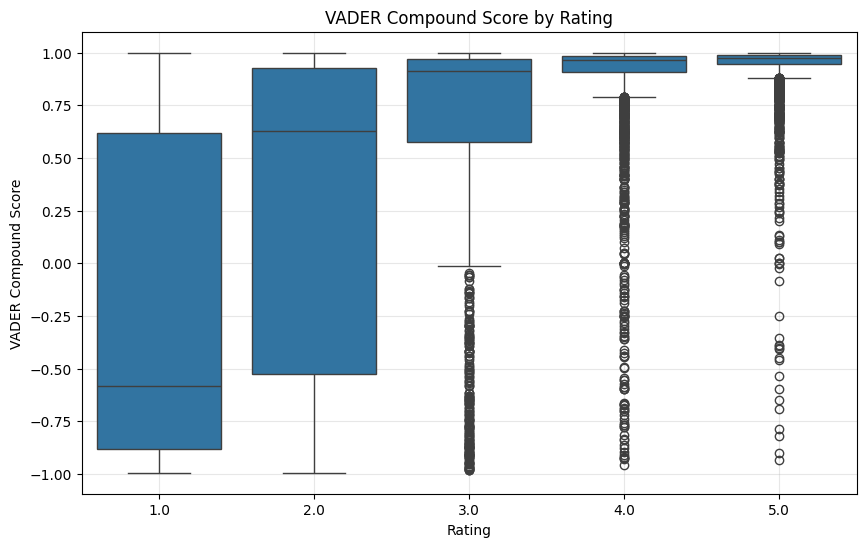

VADER MSE: 1.5539
VADER MAE: 0.8159
VADER RMSE: 1.2466


<ipython-input-7-b4bf2e479fed>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dev_df['vader_rating'] = dev_df['vader_compound'].apply(map_vader_to_rating)


In [ ]:
# Get VADER sentiment scores
def get_vader_sentiment(text):
    if not isinstance(text, str):
        return {'neg': 0, 'neu': 0, 'pos': 0, 'compound': 0}

    sid = SentimentIntensityAnalyzer()
    return sid.polarity_scores(text)

# Apply VADER to the dev dataset
dev_df['vader_scores'] = dev_df['combined_text'].apply(get_vader_sentiment)
dev_df['vader_compound'] = dev_df['vader_scores'].apply(lambda x: x['compound'])
dev_df['vader_pos'] = dev_df['vader_scores'].apply(lambda x: x['pos'])
dev_df['vader_neg'] = dev_df['vader_scores'].apply(lambda x: x['neg'])
dev_df['vader_neu'] = dev_df['vader_scores'].apply(lambda x: x['neu'])

# Visualise VADER scores vs actual ratings
plt.figure(figsize=(10, 6))
sns.boxplot(x='overall', y='vader_compound', data=dev_df)
plt.title('VADER Compound Score by Rating')
plt.xlabel('Rating')
plt.ylabel('VADER Compound Score')
plt.grid(True, alpha=0.3)
plt.show()

# Map VADER compound scores to the 1-5 scale
def map_vader_to_rating(compound):
    if compound < -0.6:
        return 1
    elif compound < -0.2:
        return 2
    elif compound < 0.2:
        return 3
    elif compound < 0.6:
        return 4
    else:
        return 5

dev_df['vader_rating'] = dev_df['vader_compound'].apply(map_vader_to_rating)

# Calculate accuracy and error metrics
vader_mse = mean_squared_error(dev_df['overall'], dev_df['vader_rating'])
vader_mae = mean_absolute_error(dev_df['overall'], dev_df['vader_rating'])
vader_rmse = np.sqrt(vader_mse)

print(f"VADER MSE: {vader_mse:.4f}")
print(f"VADER MAE: {vader_mae:.4f}")
print(f"VADER RMSE: {vader_rmse:.4f}")

The box plot shows a clear trend where higher ratings correspond to higher sentiment scores. Negative reviews (ratings of 1 and 2) exhibit a wider range of sentiment scores, including strongly negative and neutral values, while higher ratings (4 and 5) are more concentrated around positive sentiment values close to 1.

The MSE (1.5539), MAE (0.8159), and RMSE (1.2466) suggest that while VADER captures general sentiment trends, its error rates indicate limitations in precisely predicting numerical ratings, particularly for mid-range (3-star) reviews, where sentiment polarity is less distinct.

### 6. Combining VADER with the best classifier

Combined TF-IDF + VADER Model Evaluation (10-fold CV):
MSE: 0.5050
RMSE: 0.7106
MAE: 0.5584
R2: 0.6430

Classification Report (Combined Model):
              precision    recall  f1-score   support

         1.0       0.71      0.28      0.40       672
         2.0       0.32      0.33      0.32       684
         3.0       0.40      0.47      0.43      1353
         4.0       0.48      0.64      0.55      3237
         5.0       0.75      0.57      0.65      4054

    accuracy                           0.55     10000
   macro avg       0.53      0.46      0.47     10000
weighted avg       0.58      0.55      0.55     10000



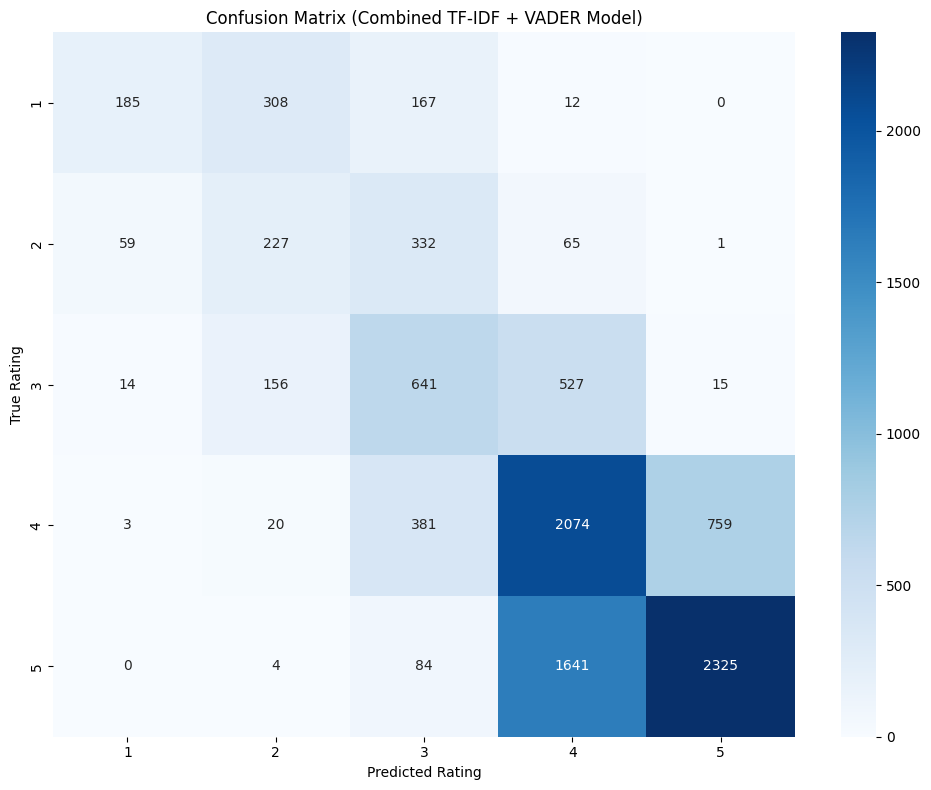

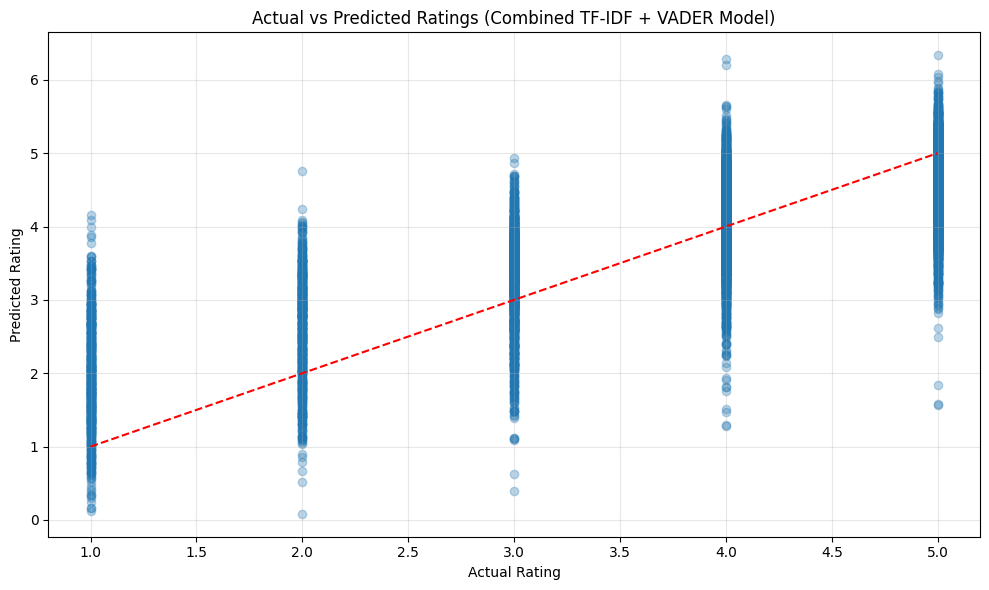

In [ ]:
# Convert continuous predictions to discrete ratings for classification metrics
def round_predictions(y_pred):
    # Round to nearest integer and clip to valid range [1, 5]
    return np.clip(np.round(y_pred), 1, 5).astype(int)

# Evaluate model with VADER + TF-IDF features
def evaluate_combined_model(dev_df):
    # Preprocess text using the best configuration
    processed_texts = [preprocess_text(text, lowercase=True)
                     for text in dev_df['combined_text']]

    # Create TF-IDF features
    vectorizer = TfidfVectorizer(max_features=5000)
    text_features = vectorizer.fit_transform(processed_texts)

    # Get VADER sentiment scores
    sid = SentimentIntensityAnalyzer()
    vader_scores = [sid.polarity_scores(text) for text in dev_df['combined_text']]

    # Extract relevant VADER features and convert to numpy array
    vader_compound = np.array([score['compound'] for score in vader_scores]).reshape(-1, 1)
    vader_pos = np.array([score['pos'] for score in vader_scores]).reshape(-1, 1)
    vader_neg = np.array([score['neg'] for score in vader_scores]).reshape(-1, 1)
    vader_neu = np.array([score['neu'] for score in vader_scores]).reshape(-1, 1)

    # Combine all VADER features
    vader_features = np.hstack([vader_compound, vader_pos, vader_neg, vader_neu])

    # Combine TF-IDF with VADER features
    # Convert vader_features to a sparse matrix for hstack with text_features
    vader_sparse = csr_matrix(vader_features)
    combined_features = hstack([text_features, vader_sparse])

    # Get target variable
    y = dev_df['overall'].values

    # Ridge model
    ridge_model = Ridge(alpha=1.0)

    # Perform 10-fold CV for combined model
    kf = KFold(n_splits=10, shuffle=True, random_state=42)
    y_pred_cv = cross_val_predict(ridge_model, combined_features, y, cv=kf)

    # Calculate metrics
    mse = mean_squared_error(y, y_pred_cv)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y, y_pred_cv)
    r2 = r2_score(y, y_pred_cv)

    # Round predictions for classification metrics
    y_pred_rounded = round_predictions(y_pred_cv)

    # Generate classification report and confusion matrix
    class_report = classification_report(y, y_pred_rounded, output_dict=True)
    class_report_df = pd.DataFrame(class_report).transpose()

    conf_matrix = confusion_matrix(y, y_pred_rounded)

    # Print results
    print("Combined TF-IDF + VADER Model Evaluation (10-fold CV):")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R2: {r2:.4f}")

    print("\nClassification Report (Combined Model):")
    print(classification_report(y, y_pred_rounded))

    # Visualise confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=range(1, 6), yticklabels=range(1, 6))
    plt.xlabel('Predicted Rating')
    plt.ylabel('True Rating')
    plt.title('Confusion Matrix (Combined TF-IDF + VADER Model)')
    plt.tight_layout()
    plt.show()

    # Plot actual vs predicted
    plt.figure(figsize=(10, 6))
    plt.scatter(y, y_pred_cv, alpha=0.3)
    plt.plot([1, 5], [1, 5], 'r--')
    plt.xlabel('Actual Rating')
    plt.ylabel('Predicted Rating')
    plt.title('Actual vs Predicted Ratings (Combined TF-IDF + VADER Model)')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Return the combined model components
    return {
        'vectorizer': vectorizer,
        'metrics': {
            'mse': mse,
            'rmse': rmse,
            'mae': mae,
            'r2': r2
        }
    }

dev_results = evaluate_combined_model(dev_df)

The SVM model using TF-IDF and VADER sentiment features on the dev dataset achieved an RMSE of 0.7106 and an R² of 0.6430, indicating a stronger correlation between predicted and actual ratings.

* The confusion matrix reveals that the model better distinguishes between positive ratings (4 and 5) while still struggling with lower ratings (1 and 2), where misclassifications remain prominent.

* The classification report supports this observation, showing higher recall for positive ratings but weaker performance for negative ones.

* The actual vs. predicted scatter plot shows that the predictions align well with actual ratings, though some spread remains, particularly for mid-range reviews.

* Incorporating sentiment scores (VADER) enhances rating predictions, but further improvements may be needed to differentiate negative sentiment more accurately.

### 7. Trainig and testing the final method

Train-Test Evaluation:
MSE: 0.5054
RMSE: 0.7109
MAE: 0.5599
R2: 0.6375

Classification Report (Test Set):
              precision    recall  f1-score   support

         1.0       0.81      0.23      0.36       643
         2.0       0.35      0.37      0.36       683
         3.0       0.41      0.52      0.46      1350
         4.0       0.47      0.63      0.54      3221
         5.0       0.74      0.56      0.64      4103

    accuracy                           0.54     10000
   macro avg       0.56      0.46      0.47     10000
weighted avg       0.59      0.54      0.54     10000



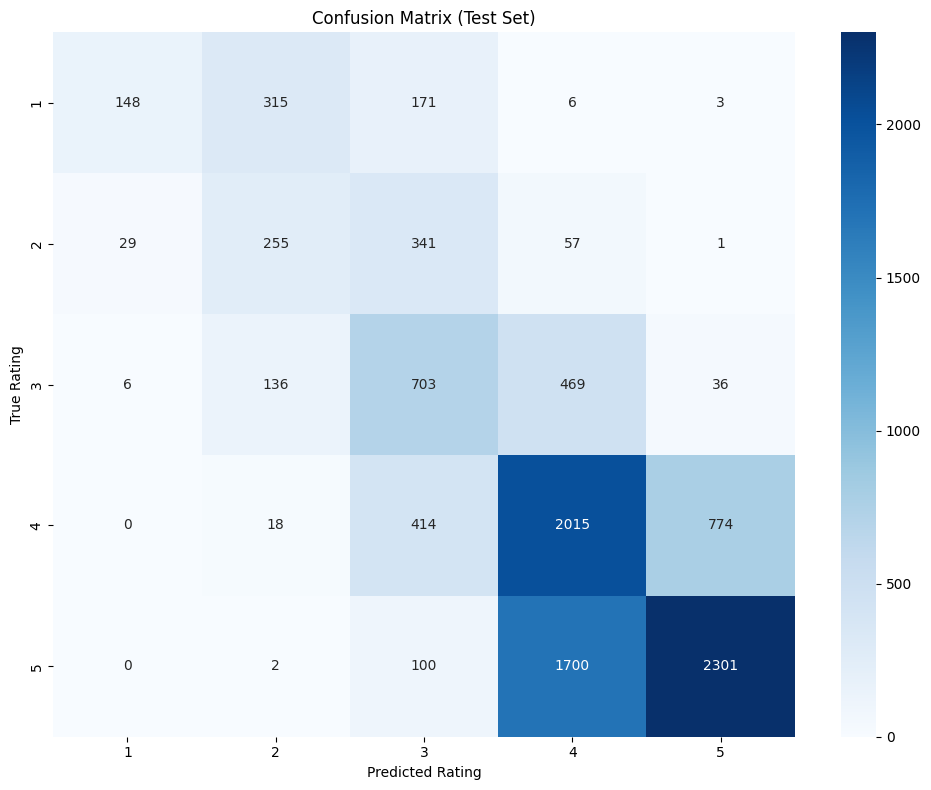

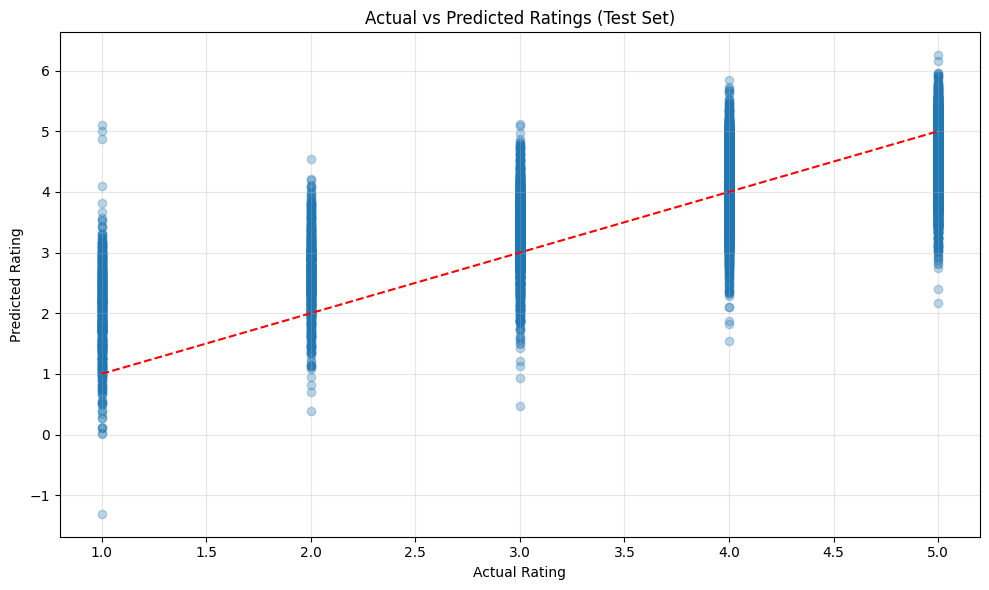

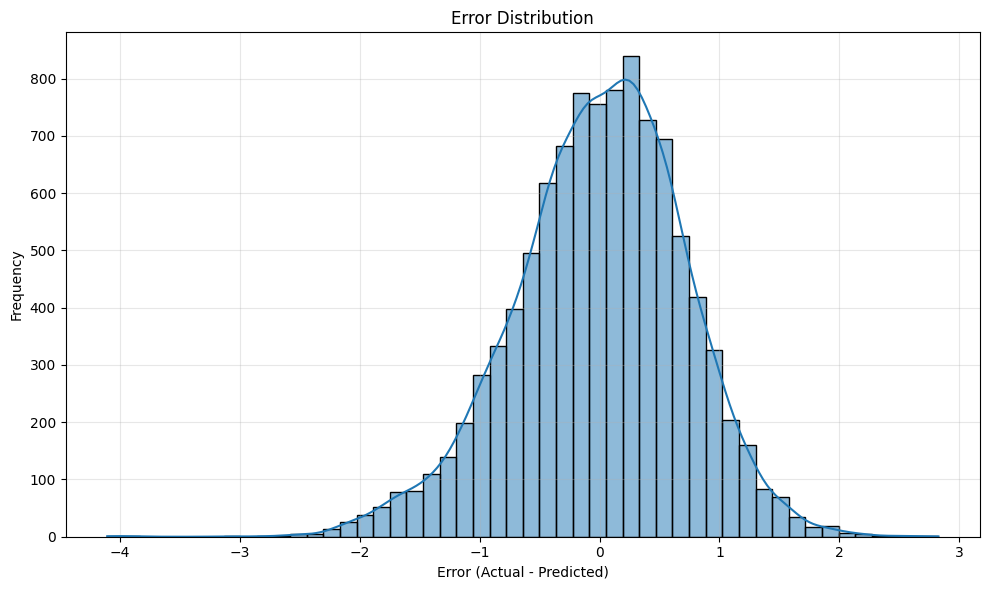

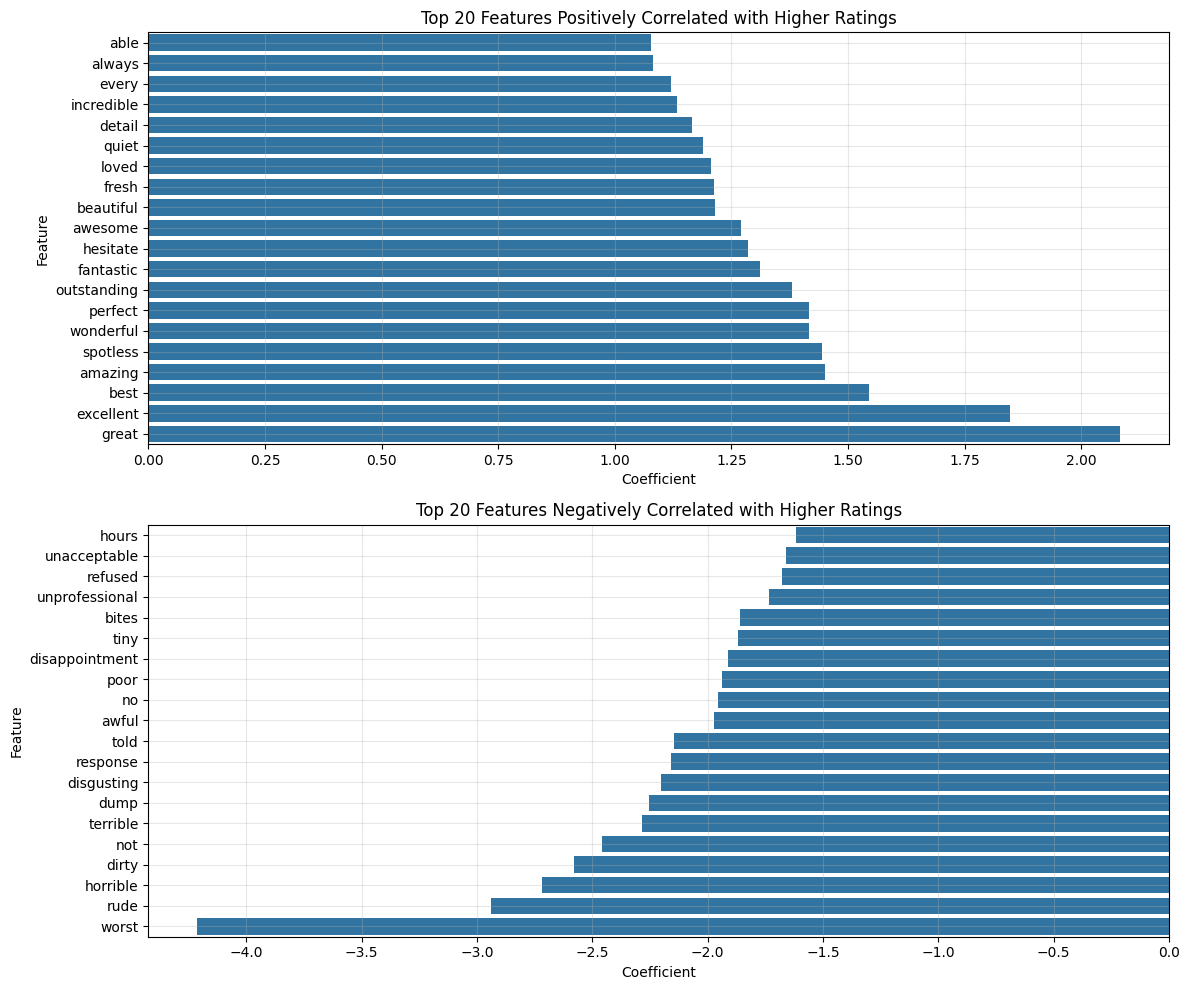


Comparison between Development and Test Performance:
Development RMSE: 0.7207
Test RMSE: 0.7109
Difference: -0.0098


In [ ]:
# Train and test the model
def train_test_final_model(train_df, test_df):
    # Preprocess text
    train_texts = [preprocess_text(text, lowercase=True) for text in train_df['combined_text']]
    test_texts = [preprocess_text(text, lowercase=True) for text in test_df['combined_text']]

    # Get target variables
    y_train = train_df['overall'].values
    y_test = test_df['overall'].values

    # Ensure labels are between 1 and 5
    y_train = np.clip(y_train, 1, 5)
    y_test = np.clip(y_test, 1, 5)

    # Create TF-IDF features
    vectorizer = TfidfVectorizer(max_features=5000)
    X_train = vectorizer.fit_transform(train_texts)
    X_test = vectorizer.transform(test_texts)

    # Train Ridge regression model
    ridge_model = Ridge(alpha=1.0)
    ridge_model.fit(X_train, y_train)

    # Make predictions
    y_pred = ridge_model.predict(X_test)

    # Calculate regression metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Round predictions for classification metrics
    y_pred_rounded = round_predictions(y_pred)

    # Generate classification report and confusion matrix
    class_report = classification_report(y_test, y_pred_rounded, output_dict=True)
    class_report_df = pd.DataFrame(class_report).transpose()

    conf_matrix = confusion_matrix(y_test, y_pred_rounded, labels=[1, 2, 3, 4, 5])

    # Print evaluation metrics
    print("Train-Test Evaluation:")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R2: {r2:.4f}")

    print("\nClassification Report (Test Set):")
    print(classification_report(y_test, y_pred_rounded, digits=2))

    # Visualise confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=np.arange(1, 6), yticklabels=np.arange(1, 6))
    plt.xlabel('Predicted Rating')
    plt.ylabel('True Rating')
    plt.title('Confusion Matrix (Test Set)')
    plt.tight_layout()
    plt.show()

    # Plot actual vs predicted
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.3)
    plt.plot([1, 5], [1, 5], 'r--')
    plt.xlabel('Actual Rating')
    plt.ylabel('Predicted Rating')
    plt.title('Actual vs Predicted Ratings (Test Set)')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Plot error distribution
    errors = y_test - y_pred
    plt.figure(figsize=(10, 6))
    sns.histplot(errors, bins=50, kde=True)
    plt.xlabel('Error (Actual - Predicted)')
    plt.ylabel('Frequency')
    plt.title('Error Distribution')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Feature importance analysis
    feature_names = vectorizer.get_feature_names_out()
    coefficients = ridge_model.coef_

    # Get top features based on coefficient magnitude
    n_top = 20
    top_positive_idx = np.argsort(coefficients)[-n_top:]
    top_negative_idx = np.argsort(coefficients)[:n_top]

    top_positive = [(feature_names[i], coefficients[i]) for i in top_positive_idx]
    top_negative = [(feature_names[i], coefficients[i]) for i in top_negative_idx]

    # Convert to DataFrames for visualisation
    top_pos_df = pd.DataFrame(top_positive, columns=['Feature', 'Coefficient'])
    top_neg_df = pd.DataFrame(top_negative, columns=['Feature', 'Coefficient'])

    # Plot top feature correlations
    plt.figure(figsize=(12, 10))

    plt.subplot(2, 1, 1)
    sns.barplot(x='Coefficient', y='Feature', data=top_pos_df.sort_values('Coefficient'))
    plt.title(f'Top {n_top} Features Positively Correlated with Higher Ratings')
    plt.grid(True, alpha=0.3)

    plt.subplot(2, 1, 2)
    sns.barplot(x='Coefficient', y='Feature', data=top_neg_df.sort_values('Coefficient', ascending=False))
    plt.title(f'Top {n_top} Features Negatively Correlated with Higher Ratings')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Compare dev and test performance
    dev_rmse = 0.7207  # From "6. Combining VADER with the best classifier"
    print("\nComparison between Development and Test Performance:")
    print(f"Development RMSE: {dev_rmse:.4f}")
    print(f"Test RMSE: {rmse:.4f}")
    print(f"Difference: {rmse - dev_rmse:.4f}")

    return {
        'model': ridge_model,
        'vectorizer': vectorizer,
        'predictions': y_pred,
        'rounded_predictions': y_pred_rounded,
        'metrics': {
            'mse': mse,
            'rmse': rmse,
            'mae': mae,
            'r2': r2
        },
        'classification_report': class_report_df,
        'confusion_matrix': conf_matrix
    }

test_results = train_test_final_model(train_df, test_df)


The Ridge regression model with TF-IDF and lowercase preprocessing achieves an RMSE of 0.7109 and an R² score of 0.6375, indicating a strong predictive ability.

* The confusion matrix highlights that the model performs well on higher ratings (4 and 5) but struggles with lower ratings (1 and 2), which are frequently misclassified.

* The classification report confirms this trend, with higher precision and recall for positive ratings, while negative ratings show lower recall, indicating difficulty in distinguishing negative sentiment effectively.

* The actual vs. predicted scatter plot shows alignment along the expected trend but with noticeable variance, particularly for mid-range reviews, suggesting some uncertainty in predictions.

* Compared to the [combined TF-IDF + VADER model](https://colab.research.google.com/drive/1ZUjUKK_M4nBKUIUa1RtY0Q7HArekJAW3#scrollTo=g1cVjb1Kv0gT&line=119&uniqifier=1), this model performs similarly, indicating that sentiment features may not provide substantial additional value for the overall rating prediction.

* The error distribution plot follows a near-normal distribution centered around zero, indicating that the errors are relatively balanced.

* The feature importance analysis highlights the top words most strongly associated with higher and lower ratings. Positive words such as "great," "excellent," "amazing," and "spotless" exhibit high positive correlations with higher ratings, while negative words like "worst," "rude," "horrible," and "dirty" are highly correlated with lower ratings.

* The comparison of development and test performance shows minimal difference (RMSE difference: -0.0098), suggesting that the model generalises well across datasets, with test RMSE (0.7109) slightly improving over the development RMSE (0.7207).

***This stability indicates the robustness of the TF-IDF + Ridge regression approach in predicting review scores.***

### **Explanation of results obtained using TF-IDF + VADER and TF-IDF + Ridge regression models**

The evaluation of predictive performance was done using RMSE and R², as these metrics are most appropriate for continuous rating predictions. RMSE quantifies the absolute deviation of predictions from actual ratings, providing an interpretable measure in the same unit as the target variable, while R² indicates the proportion of variance explained by the model.

The comparison between TF-IDF + Ridge regression (on the train-test datasets) and TF-IDF + VADER (on dev dataset) revealed that incorporating VADER sentiment scores did not significantly improve performance (RMSE: 0.7106 vs. 0.7109), suggesting that TF-IDF features alone effectively capture sentiment-related information.  

A possible reason for this result is that TF-IDF already encodes sentiment-laden terms (e.g., "excellent," "amazing," "horrible," and "dirty") with strong associations to ratings, making the additional sentiment score redundant.

VADER's sentiment lexicon is optimised for general-purpose sentiment analysis, and may not fully capture nuances in hotel reviews, where domain-specific expressions and expectations influence sentiment perception.

The inclusion of VADER may introduce feature redundancy or multi-collinearity, leading to marginal performance gains. Given the similar predictive accuracy, the TF-IDF + Ridge Regression model is preferable due to its lower complexity and strong generalisability, as demonstrated by the minimal RMSE difference between the development and test sets (0.0098).

### 8. Reviews aspect prediction

#### **Multi-Aspect Hotel Rating Prediction via Multi-Output Regression**

This proposal aims to enhance hotel rating prediction through a multi-output regression framework, shifting from a singular overall rating to granular aspect-specific evaluations comprising of service, cleanliness, location, rooms, value, and sleep quality. Rather than predicting a single overall rating, the model would generate distinct scores for each aspect based on the review content, including both the title and text. This method enables a deeper understanding of customer feedback, allowing for a comprehensive assessment of various factors influencing guest satisfaction.

The methodology starts with data preprocessing, involving stop-word removal, lemmatization, and tokenization to normalise textual data. Feature extraction will leverage TF-IDF vectorisation to capture term importance (Ramos, 2003), supplemented by pre-trained BERT embeddings for semantic contextualisation (Devlin et al., 2019). Sentiment polarity, quantified via VADER scores (Hutto & Gilbert, 2014), will be integrated as supplementary features, and aspect-specific opinion lexicons, derived from domain-specific corpora, will be employed to augment feature representation. These lexicons, containing terms strongly associated with each hotel aspect, will either be used as additional features or to weight the importance of specific words within the TF-IDF vectors, enhancing the model's ability to discern aspect-specific sentiments.

The predictive modeling phase will adopt a multi-output regression strategy, treating each aspect rating as a continuous target variable. Model selection will encompass regularized linear regression (Ridge) (Hastie et al., 2017), Random Forest regression for non-linear relationships and feature importance analysis (Biau & Scornet, 2016), and neural network architectures including fine-tuned BERT models, MLPs, and RNNs. A multi-task learning approach will be implemented to leverage shared text representations, improving generalisation across aspect ratings (Zhang & Yang, 2021). Model evaluation will utilise metrics such as MSE, RMSE, MAE, and R², calculated for each aspect. Cross-validation techniques, specifically k-fold cross-validation, will ensure robust model evaluation, while grid or random search will optimise hyperparameters.

Addressing the challenge of missing aspect mentions, the absence of specific aspects will be treated as a feature. Imputation techniques may be explored to predict missing ratings, and attention mechanisms within neural networks will be utilsed to focus on relevant review segments (Vaswani et al., 2017), and is expected to give a more insightful understanding of customer feedback.

However, challenges such as data imbalance and the need for extensive labeled data will necessitate careful consideration. The integration of sentiment polarity and aspect-specific lexicons is anticipated to significantly enhance the accuracy and granularity of aspect rating predictions, providing a more comprehensive and actionable analysis of customer reviews.

**References**

Biau, G., & Scornet, E. (2016). A random forest guided tour. *Test*, *25*(2), 197-227.

Devlin, J., Chang, M. W., Lee, K., & Toutanova, K. (2019). BERT: Pre-training of deep bidirectional transformers for language understanding. In *Proceedings of the 2019 Conference of the North American Chapter of the Association for Computational Linguistics: Human Language Technologies, Volume 1 (Long and Short Papers)* (pp. 4171-4186).

Hastie, T., Tibshirani, R., & Friedman, J. (2017). *The elements of statistical learning: data mining, inference, and prediction*. Springer science & business media.

Hutto, C. J., & Gilbert, E. E. (2014). VADER: A parsimonious rule-based model for sentiment analysis of social media text. In *Proceedings of the eighth international AAAI conference on weblogs and social media*.

Ramos, J. (2003). Using TF-IDF to determine word relevance in document queries. In *Proceedings of the first instructional conference on machine learning* (Vol. 242, pp. 133-142).

Vaswani, A., Shazeer, N., Parmar, N., Uszkoreit, J., Jones, L., Gomez, A. N., ... & Polosukhin, I. (2017). Attention is all you need. In *Advances in neural information processing systems* (pp. 5998-6008).

Zhang, Y., & Yang, Q. (2021). A survey on multi-task learning. *IEEE Transactions on Knowledge and Data Engineering*, *34*(12), 5589-5609.

### 9. References

Jurafsky, D. & Martin, J.H., Speech and Language Processing: An Introduction to Natural Language Processing, *Computational Linguistics, and Speech Recognition*.

Sarker, O. (2025) Applied Natural Language Processing [Lecture], COMP_SCI_7417: Sentiment Analysis. *The University of Adelaide.* 13 May 2025.

Sarker, O. (2025) Applied Natural Language Processing [Workshop], COMP_SCI_7417: Workshop Week 2. *The University of Adelaide.* 14 May 2025.

